**Note:** This project must be submitted as a jupyter notebook (.ipynb extension)

---

### Searching for periodic signals in light-curves to find variable stars and exoplanets

Many stars exhibit periodic changes in brightness. For some single stars this is intrinsic (similar to the Solar cycle seen in our own Sun but much more rapid) and may be due to large star spots on the stellar surface, or to pulsations which can cause significant changes in temperature and radius. Other stars exist in binary systems, as the perceived brightness as seen from Earth will vary as they mutually occlude each other as they proceed in the orbits.

More excitingly for a small fraction of stars that host their own planets there may be a chance alignment between the orbital plane of the exoplanet and our line-of-sight to the star. In these cases the exoplanet will periodically pass between the star and us, blocking a small fraction of light (typically <1%). By taking very high-precision light-curves of many stars and searching for small periodic signals we can discover new exoplanets. 

Included in the 'data' sub-directory are several data files containing light-curves obtained using the NASA satellite _TESS_ (Transiting Exoplanet Sky Survey). A quick note on nomenclature - a light-curve is what astronomers call a photometric time-series, ie. a series of brightness / flux measurements taken at specific times.

The attached files contain the following columns:
- time, in days
- flux (brightness) in arbtrary units
- flux error (1$\sigma$) in those same units

You should be able to read these files using numpy functions you are familiar with. The values of the time stamps are quite large, so for help with plotting, etc., it is best to subtract the minimum time value from the time array after reading the file.

Here we will use a technique called Phase Dispersion Minimization (PDM) to identify the periods of the handful of variable stars and exoplanets in the _TESS_ light-curves.

At it's core this method relies on the concept of _phase-folding,_ which works as follows. Assume you have a light-curve of a target star whose brightness varies in some periodic fashion with a period $P_{\rm true}$, and that that light-curve contains series of sample times $t_i$ and measured brightness $f_i$. For a given trial period, $P_{\rm guess}$, you can compute a phase value $\phi_i = (t_i\mod P_{\rm guess}) / P_{\rm guess}$. You can plot $f_i$ against $\phi_i$, and if you have guessed the period correctly you will see the flux measurements from each cycle line up nicely and overlay each other. If you have guessed the wrong period, you will generally just get a scattered mess.

What PDM does is to attempt to compute a single statistical  measure of how closely the data points line up and overlay as a function of phase. This is not as simple as it sounds, as real data contains noise from various sources, eg. counting statistics, and various instrumental and environmental influences on the satellite. The data you will be using here have been quite thorougly cleaned to remove most (but not all) of these effects.


### A demonstration of phase-folding

If you have not come across phase-folding before, it's best to try a simple example, and hopefully a few simple plots will make the point clear.

The code below does the following:
- generates a list of sample times covering an interval of, say 100 days, using 0.01 day sampling
- generates a list of simulated fluxes measured at those times using a periodic function, in this case a sine function with a period of $P_{\rm true}=1$ day
- adds a small amount of Gaussian random noise to the fluxes (5%) of the amplitude of the sine function
- computes the phases $\phi_{\rm good}$ for the chosen period ($P_{\rm true}$) and plots the simulated fluxes versus $\phi_{good}$.
- computes the phases $\phi_{\rm bad}$ for some other period ($P_{\rm bad}$) and plots the simulated fluxes versus $\phi_{bad}$.

What you should see is that when you phase-fold on the correct period the plotted curve (which should be blue) is a clear sinusoid trend, and the data points group tightly around that trend. For the phase-fold on the incorrect period (orange) the points are all over the place - there is a lot of scatter at all phases and sinusoidal signal is not evident.

**Exercise:** Try changing the value of $P_{\rm bad}$ and re-creating the plot. What you should see is for most values the scatter in the orange points remains large. However if you choose periods that are close to $P_{\rm good}$, say 1.001, 1.002, 1.005, etc. you can still see the signature of the underlying sinusoidal variation, but it is progressively smeared out as you move away from the true value of $P_{\rm good}$. Likewise if you choose a period close to an integer multiple of $P_{\rm good}$ you will see multiple cycles of the sinusoid, but still tightly grouped. Play around a little until it makes sense. **Note.** there are no marks to be awarded for this exercise, but the rest of the project will make a lot more sense if you take the time to do it.

In [1]:
# Import some modules and functions

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nr
from math import pi, fabs
plt.rcParams['figure.figsize'] = [14, 8]

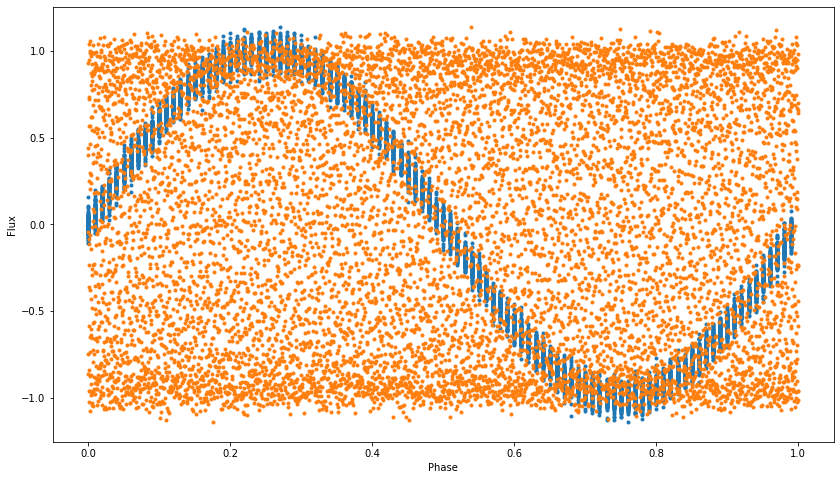

In [2]:
'''
A demonstration of phase-folding
'''

# Create the simulated light-curve
p_true = 1.0
t = np.arange(100.0, step=0.01)
f = nr.normal(np.sin(2 * t * pi / p_true), 0.05)

# Phase-fold on the true period and plot
p_good = p_true
phi_good = np.mod(t, p_good) / p_good
plt.plot(phi_good, f, '.')

# Phase-fold on an incorrect period and plot
p_bad = 1.234567
phi_bad = np.mod(t, p_bad) / p_bad
plt.plot(phi_bad, f, '.')

# Add some labels
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.show()

### Formalising the PDM method
As you should be able to see from the simple example above, the concept is relatively simple. If you have a one or a few light-curves with clear and strong periodic signals you could just try to guess the correct periods, making the plot above and tweaking your guess until you get it right. Obviously though if you have hundreds, thousands or millions of light-curves this is not a sustainable solution so we need to automate this process.

Consider a light-curve with $N$ observations, firstly we compute the mean flux value, $\bar{f}$. We then fold at a trial period $p$ and binned the fluxes into $M$ phase bins. For each bin we compute the mean flux, $f_j$, and count the number of points, $n_j$, that fall into it. We then compute a measure of variance of mean fluxes in the phase bins about the global mean:

$$A = \sum_{j=1}^{M} n_j\left(\bar{f_j} - \bar{f}\right)^2$$

We also compute the sum of all of the variances of the individual bins:

$$E = \sum_{j=1}^{M}\sum_{k=1}^{n_j}\left(f_{kj}-\bar{f_j}\right)^2$$

where $f_{kj}$ is the $k$th data value in the $j$th bin. Lastly we compute the ratio of these two values thus:

$$S=\frac{(N-M) A}{(M-1) E}$$

The basic point here is that this $S$ statistic is larger when the variance of the data points in the individual phase bins ($E$) is smaller, and when the variance of the binned mean fluxes ($A$) is larger. This generally corresponds to the case where the trial period is close to the true period, _or an integral multiple or fraction of it_.

### Automating the period search
Now that we have a statistic intended to measure how "good" a given trial period is we can automate the search. The simplest technique is to generate a list of trial periods $P_i$ between a defined lower and upper limit and a chosen sampling, then to compute the value of $S(P_i)$. The result is usually referred to as a periodogram (in astronomy circles at least!).

We need to make sensible choices for the minimum and maximum trial period and the sampling interval. Much of this is guided by experience but there are a couple of useful rules of thumb based on information we have about how _TESS_ gathers data. The satellite surveys the sky by pointing at a specific patch for $\sim$27 days before moving on (actually two pointings of $\sim$13 days with a day in between to download data to Earth). This means that typically we will get light-curves of a maximum of 27 days duration. We need to see at least two full cycles of our periodic signal so we can be sure we have measured the period correctly, so there is little point in searching for periods longer than 13 days. Secondly _TESS_ acquires a data point every 30 minutes so for a minimum period there is no point in going shorter than a few hours. For the sampling interval you need to sample finely enough that you don't miss a best period, but not so long that the search consumes too much CPU time. A few hundred thousand samples is usually more than enough.

The second important choice to be made is the number of phase bins ($M$) to use. This is something of a black art, and is something that you will need to experiment with. Typically 10 to 30 works well, but it really depends on the shape of the folded lightcurve.

### Project
You are supplied with ten data files containing _TESS_ light-curves of known variable stars, and transiting exoplanets discovered by the WASP project.

Write an application that for each light-curve:
- reads the data file
- plots the _TESS_ light-curve (flux against time, including error bars)
- computes the periodogram using the $S$ statistic as outlined above
- plots the periodogram
- chooses the best / most significant period
- plots a phase-folded light-curve for this best period
- prints the best period
- for the WASP planets prints the percentage fractional difference between your best period and the true period, ie. $100 * (P_{\rm best} - P_{\rm true})/P_{\rm true}$.

**Hint**: assess your phase-folded plots carefully to convince yourself that the search algorithm has chosen the correct period. It is not uncommon for these automated algorithms to chose a "best" period which is an integer multiple or fraction of the true period, with twice and one-half being most commmon. If you have more than two minima in your folded light-curve, you very likely have the wrong period. If this happens you can manually tweak the period used to create the final phase-folded plot.

**Hint**: for the WASP planets you can find the true period using Google, which will lead you either to Wikipedia or the exoplanet.eu database. By tweaking the parameters you use to define the search you should be able to recover the true period to better than 0.1%, and in most cases better than 0.01%.

#### Marking
Two marks will be awarded per supplied light-curve for finding a plausible best-fitting period (1 mark) and creating the plots as described with sensible axis scales and labels (1 mark). **Note:** _for the WASP planets the first mark will **only** be awarded if your best-fitting period is within 0.1% of the true period_.

#### Submitting this project
This project must be submitted as a jupyter notebook (.ipynb extension)

In [3]:
""" Our code"""

# INSERT YOUR CODE HERE

import numpy as np
import matplotlib.pyplot as plt


class Model:
    """Our Model"""

    def __init__(self, pathtodata, binamount=20):
        # Number of bins
        self.bins = binamount
        # Storing the data in the class obj
        data_obj = np.genfromtxt(pathtodata)
        # Extracting time
        self.time = data_obj[:, 0]
        # Extracting flux
        self.flux = data_obj[:, 1]
        # Extracting flux_error
        self.flux_err = data_obj[:, 2]
        # Creating the title
        self.title = (pathtodata.rsplit("/")[-1]).rsplit("_")[0]
        # Creating a tuple to hold our Period results:
        self.presults = None
        # Presults = (time,s,bestperiod)
        # Used classes, as it creates a unqiue object for each experiment
        # Note that self.VARIABLENAME means that the variable is owned
        # by that classs

    def PERIODIZE(self, period):
        """Periodize the time array"""
        # Periodize time  (t mod p)/ p
        return np.mod(self.time, period) / period

    def BINNED_ARRAYS_OP(self, bin_edges, point_count, p_time):
        """Operating on binned arrays to get A & E"""
        # Get the mean flux
        meanflux = np.mean(self.flux)
        # Set E_STAT to zero
        E_STAT = 0
        # Set A_STAT to zero
        A_STAT = 0
        for i in range(0, self.bins):
            # Get the fluxes in each mean
            # In particular, the code will find the find the corresponding
            # fluxes of the times contained in the bin periodised by our
            # time p
            forw = bin_edges[i + 1]
            back = bin_edges[i]
            curr_arr = self.flux[(back <= p_time) & (p_time < forw)]
            # Some times, we get an empty array
            if curr_arr.size != 0:
                # Find the mean of each bin array
                mean_flux_curr = np.mean(curr_arr)
                # Find the variance of each bin and added to E_STAT
                # E  = \sum_{1}^{M} \sum_{1}^{nj} (f_j - mean_flux_bin )**2
                # Note tha the calculation is vectorised
                E_STAT += np.sum((curr_arr - mean_flux_curr) ** 2)
                # Find the A_STAT for each bin and added
                # A  = \sum_{1}^{M} n_j * (mean_flux_bin - mean_fux)**2
                mean_bin_diff = (mean_flux_curr - meanflux) ** 2
                A_STAT += point_count[i] * mean_bin_diff

            # Return a tuple with (E_Stat,A_Stat)
        return (E_STAT, A_STAT)

    def S_STAT(self, period):
        """Getting S_stat"""
        # Get the len of flux
        Nf = len(self.flux)
        # Periodize the time according to the period
        p_time = self.PERIODIZE(period)
        # Find the points and edges of each bin
        point_count, bin_edges = np.histogram(p_time, bins=self.bins)
        # print(bin_edges) # TESTING PURPOSES
        # Caclulate the A and E statistics
        E_stat, A_stat = self.BINNED_ARRAYS_OP(bin_edges, point_count, p_time)
        # Return S = (N-M)*A / ( (M-1)*E )
        return ((Nf - self.bins) * A_stat) / ((self.bins - 1) * E_stat)

    def FIND_PERIOD(self, search):
        """Finding our Period"""
        # Creates our time search,
        # From 0.1 of a day to 13 days as specified
        time_search = np.linspace(search[0], search[1], search[2])
        # Using Vectorise to apply S_STAT to our time array
        S_array = np.vectorize(self.S_STAT)(time_search)
        # print(S_array)
        # finding the best period
        best_period = time_search[np.argmax(S_array)]
        # Assign it to our p results variable
        self.presults = (time_search, S_array, best_period)

    def PERIODOGRAM(self):
        """Creating a Periodogram"""
        # If no self.presults, it will return with an Value Error
        if self.presults is None:
            raise ValueError(
                """
                Cannot generate periodogram without data
                Please run object.FIND_PERIOD before running PERIODGRAM"""
            )
        # print(self.presults)
        plt.figure(figsize=(16, 9))
        plt.grid(True)
        plt.xlabel("Time (Days)", fontsize=18)
        plt.ylabel("S(t)", fontsize=18)
        plt.title(f"{self.title} Periodogram", fontsize=18)
        plt.plot(self.presults[0], self.presults[1])
        plt.show()

    def PHASE_FOLD(self, bperiod):
        """Defining our Phase Fold"""
        # If no self.presults, it will return with an Value Error
        if self.presults is None:
            raise ValueError(
                """
                Cannot generate periodogram without data
                Please run object.FIND_PERIOD before running PHASE_FOLD"""
            )
        # Time periodised by the best period
        bp_time = self.PERIODIZE(bperiod)
        plt.figure(figsize=(16, 9))
        plt.grid(True)
        plt.xlabel("Time periodized by P", fontsize=18)
        plt.ylabel("Flux", fontsize=18)
        plt.title(f"{self.title} Phasefold at P={bperiod:.4f}", fontsize=18)
        plt.scatter(bp_time, self.flux)
        plt.show()

    def TESS_CURVE(self):
        """Creating Tesss Curve"""
        # Gets the minimum time
        min_t = np.min(self.time)
        # Minuses the minimum time from our time
        time = self.time - min_t
        plt.figure(figsize=(16, 9))
        plt.grid(True)
        # Creates the error plot
        plt.errorbar(
            time,
            self.flux,
            self.flux_err,
            fmt="o",
            linestyle="none",
            markersize=5,
            elinewidth=2.5,
            ecolor="red",
            label="Data +- Error",
        )
        plt.xlabel(f"Time (+{min_t: 0.3E}s)", fontsize=18)
        plt.ylabel("Flux", fontsize=18)
        plt.title(f"{self.title} TESS curve", fontsize=18)
        plt.legend(fontsize=18)
        plt.show()
        # Plots the TESS Curve

    def MAIN(self, true_value=None, ov_p=None, search=None):
        """Main Function"""
        # Concatentates all the previously defined functions into a single
        # main code
        # Defaulting Search
        if search is None:
            search = [0.1, 13, 3000]
        self.FIND_PERIOD(search)
        self.TESS_CURVE()
        self.PERIODOGRAM()
        # If you want to set a custom period
        # you can be setting
        if ov_p is None:
            bp = self.presults[2]
        else:
            if ov_p == -1:
                bp = self.presults[2] * 2
            elif ov_p > 0:
                bp = ov_p
            else:
                raise ValueError("Period can't be negative")
        self.PHASE_FOLD(bp)
        print(f"Best Period : {bp}")
        if true_value is not None:
            diff = np.abs(bp - true_value) / true_value
            print(f"Relative Error : {100*diff}%")


# Please HASH OUT any Testing code here
# X = Model("./data/WASP-7_TOI-2197_FLUX.dat", 30)
# print(X.S_STAT(1.6284246))
# print(X.FIND_PERIOD()[1])
# X.FIND_PERIOD()
# X.PERIODOGRAM()
# X.PHASE_FOLD()
# plt.plot(graph[0],graph[1][0])
# plt.xlim(3,4)
# X.TESSCurve()
# print(__name__)
# X.MAIN()


## TIC-8170664S_array

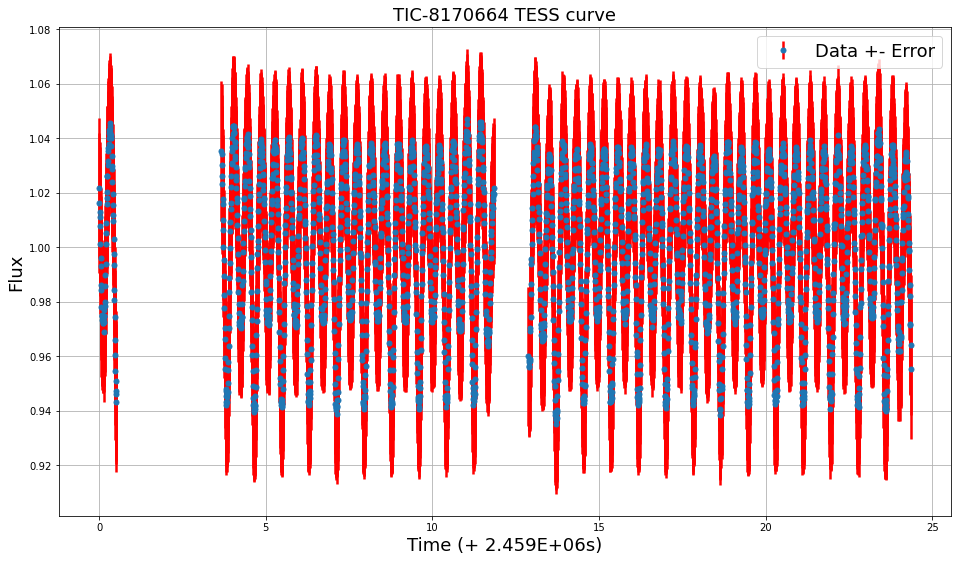

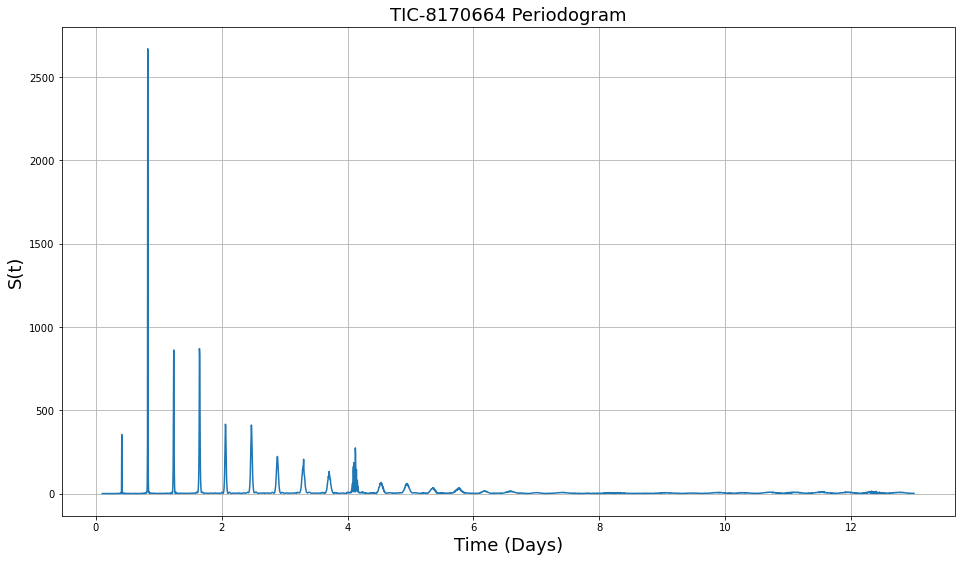

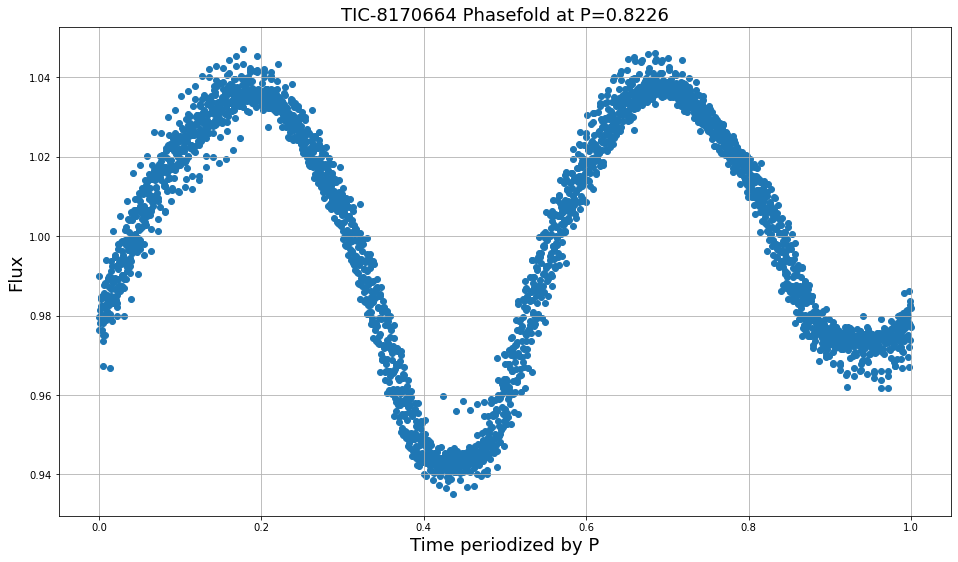

Best Period : 0.8226408802934312


In [4]:
""" TIC-816 """
Star = Model("./data/TIC-8170664_EA2_FLUX.dat")
Star.MAIN()


## RU Lep

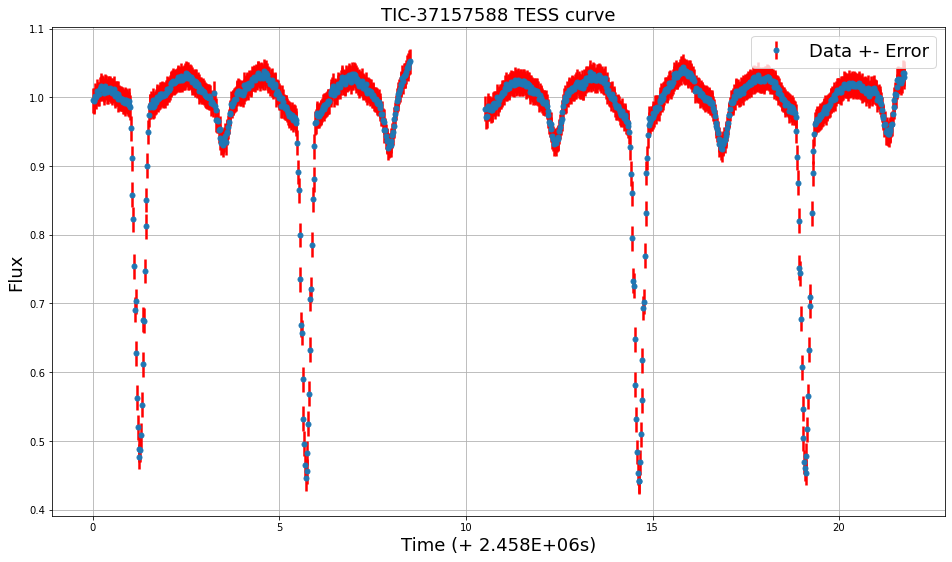

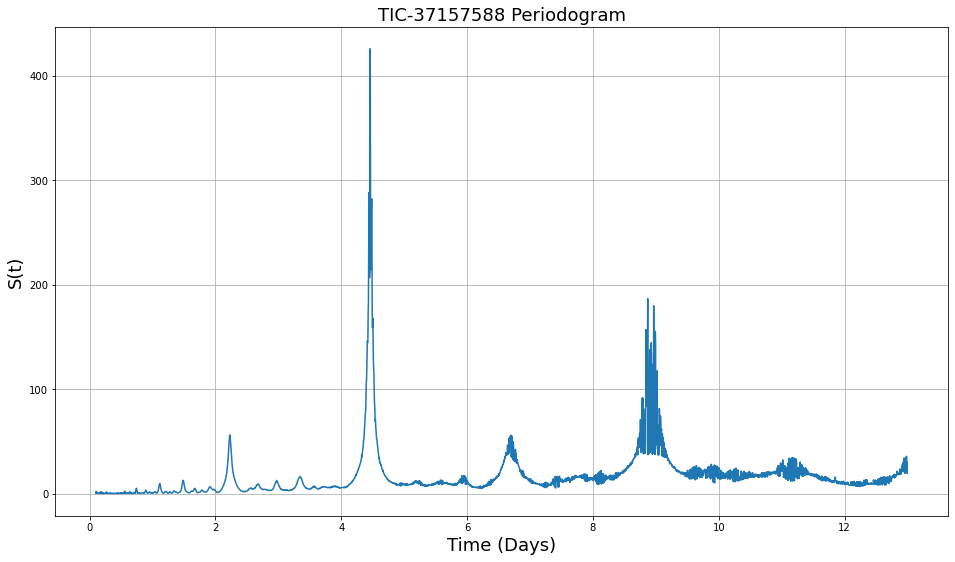

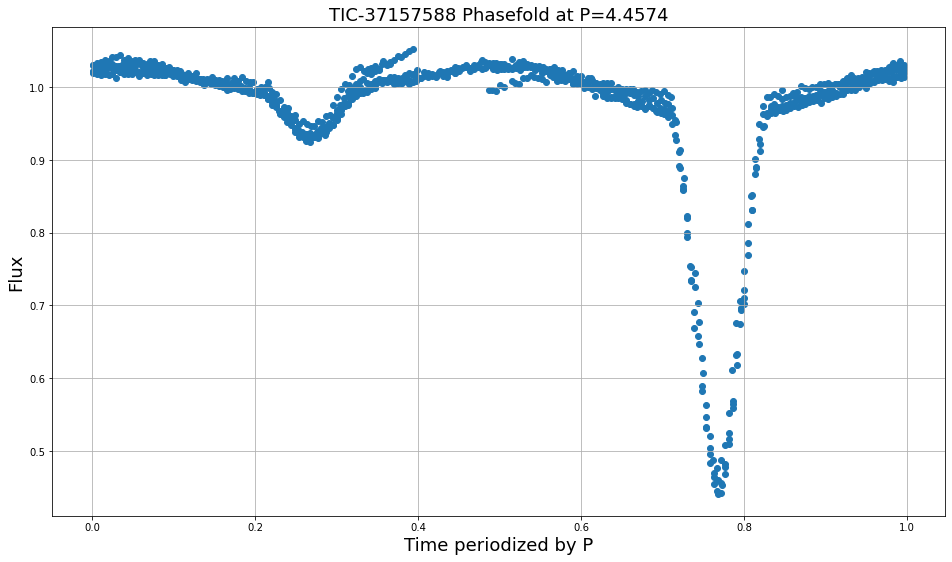

Best Period : 4.457352450816939


In [5]:
""" RU Lep """
Star = Model("./data/TIC-37157588_RU_lep_FLUX.dat")
Star.MAIN()


## TIC-61213992

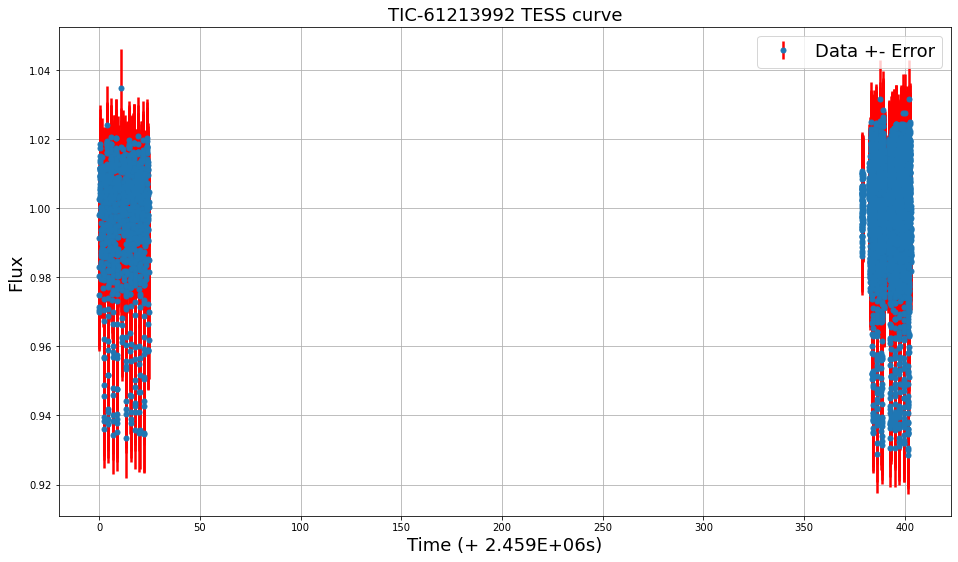

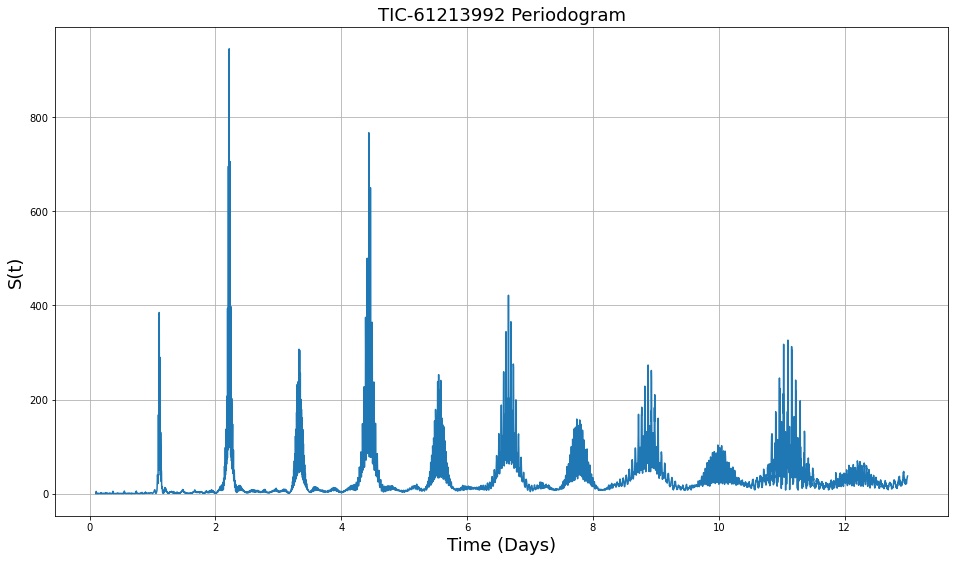

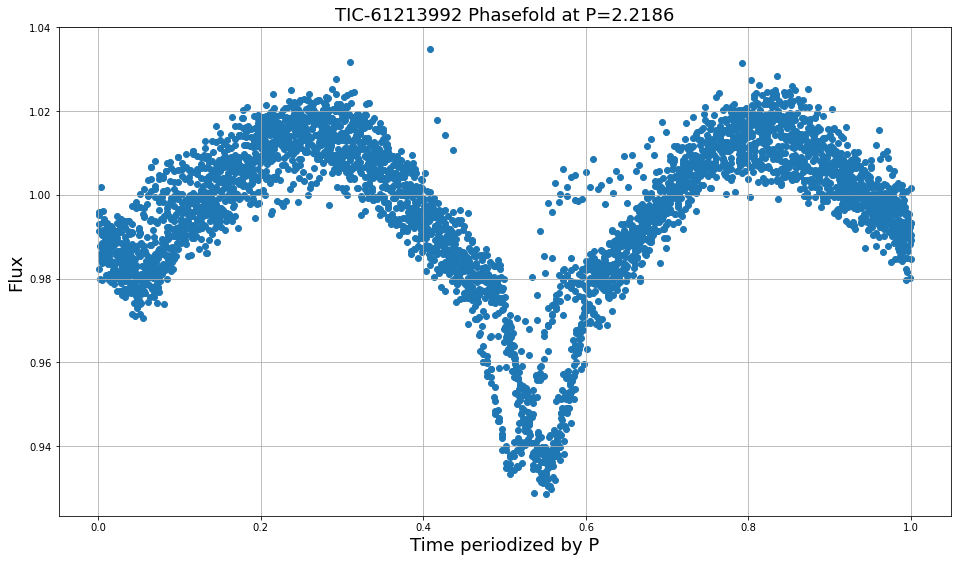

Best Period : 2.2186037207441487


In [6]:
""" TIC-61213992 """
Star = Model("./data/TIC-61213992_EA2_FLUX.dat")
Star.MAIN(search=[0.1, 13, 5000])


## RV Crt

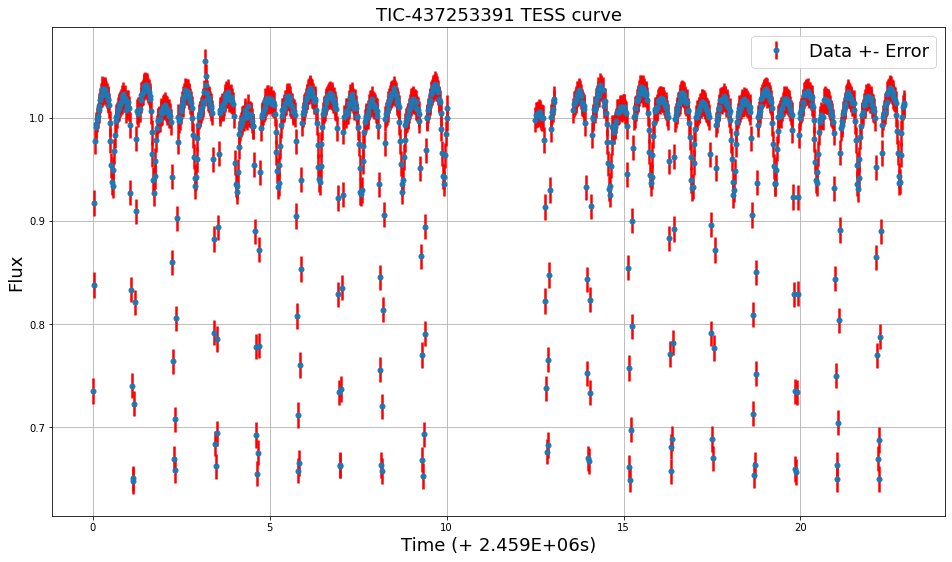

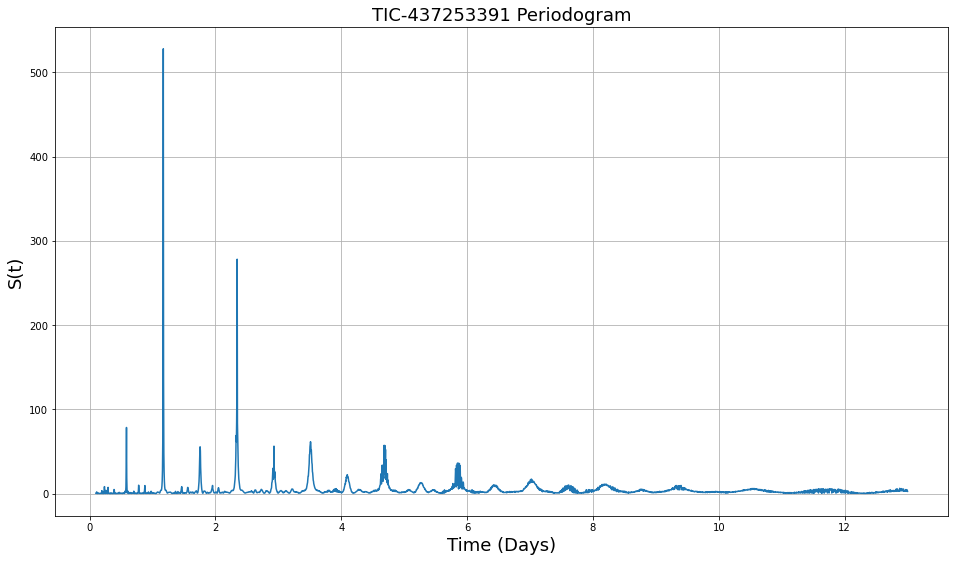

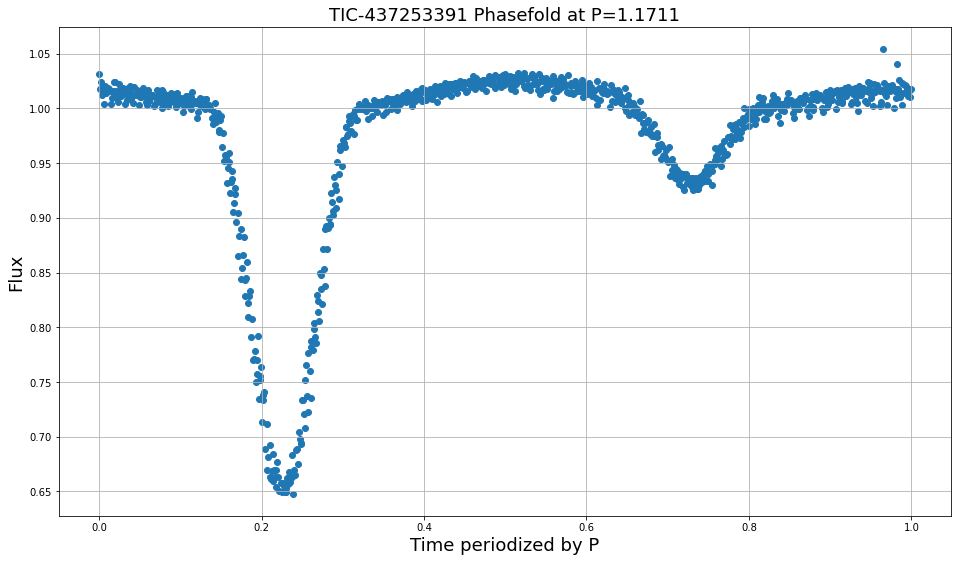

Best Period : 1.1710570190063356


In [7]:
""" RV Crt """
Star = Model("./data/TIC-437253391_RV_crt_FLUX.dat")
Star.MAIN()


## TIC-61332742

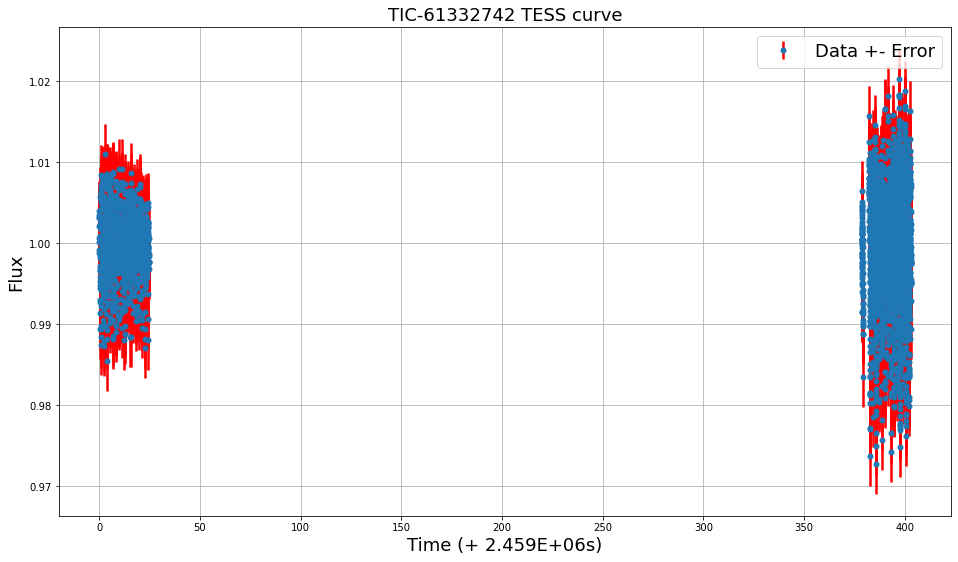

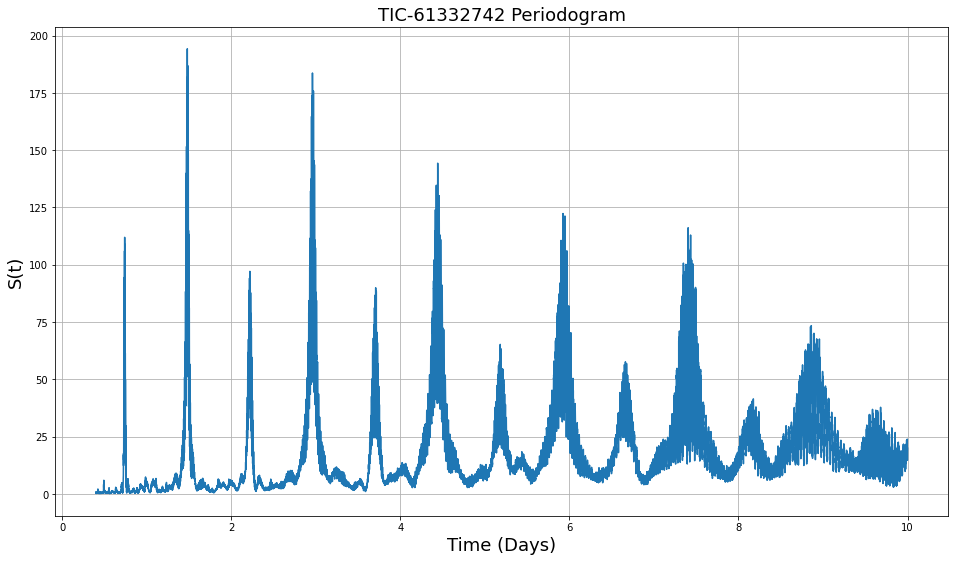

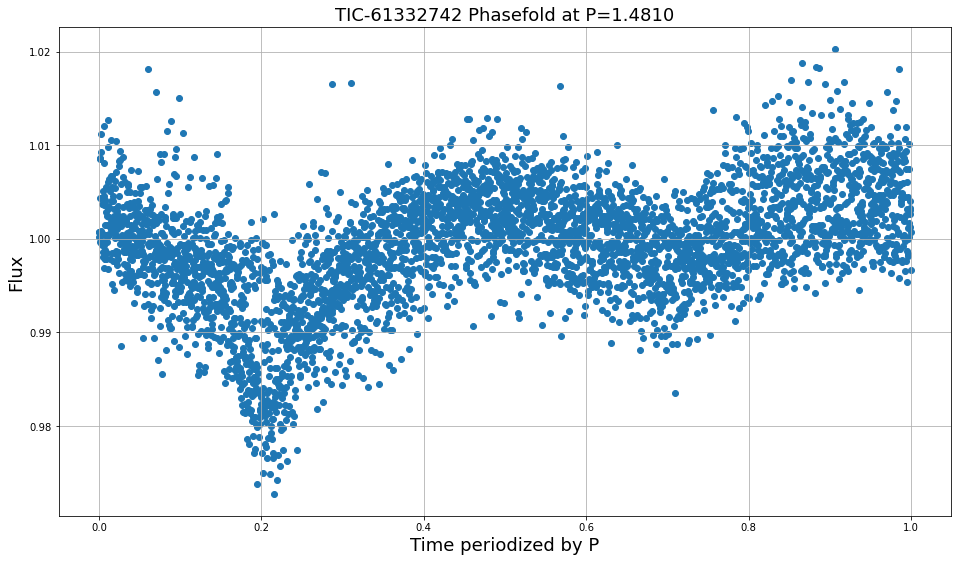

Best Period : 1.4810140507025351


In [8]:
""" TIC-61332742 """
Star = Model("./data/TIC-61332742_Ellipsoidal_secondary_FLUX.dat")
Star.MAIN(search=[0.4, 10, 20000])


## WASP-5b

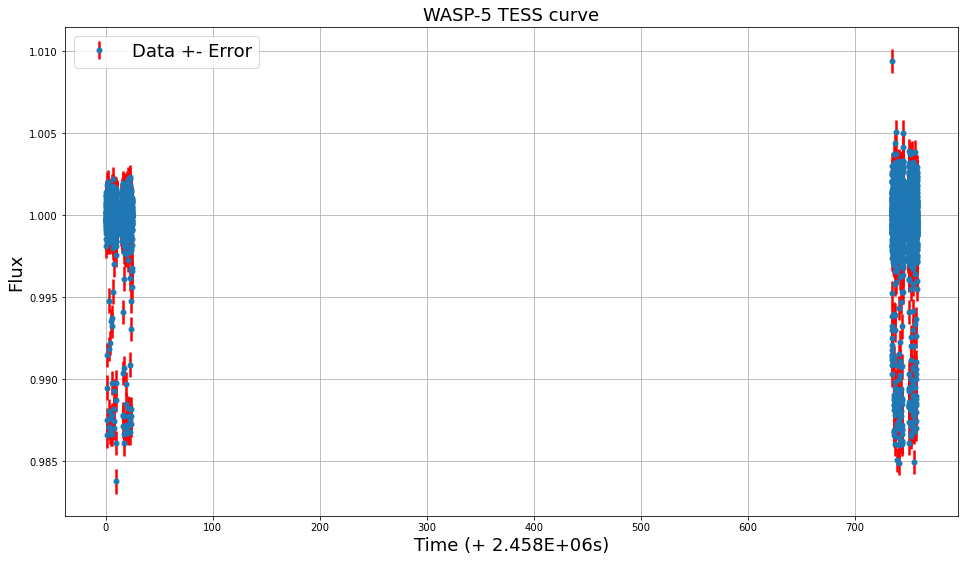

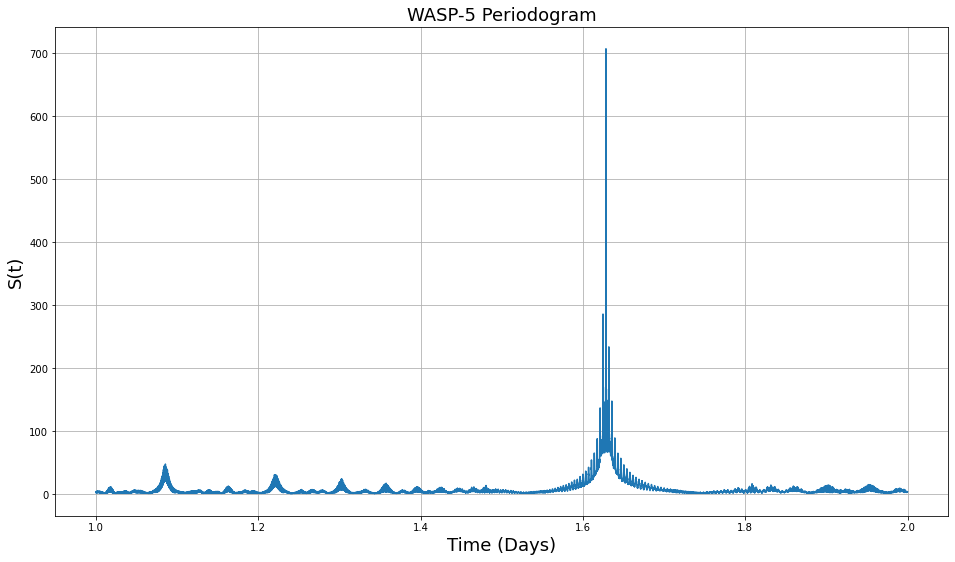

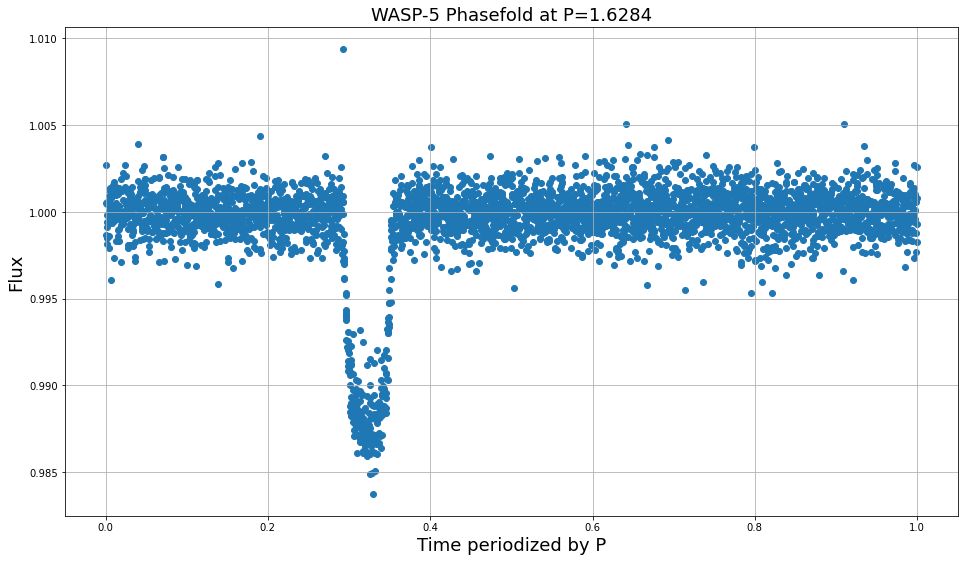

Best Period : 1.6284314215710785
Relative Error : 0.0004189061672522322%


In [9]:
""" WASP-5b """
Star = Model("./data/WASP-5_TOI-250_FLUX.dat")
Star.MAIN(1.6284246, search=[1, 2, 20000])


## WASP-7b

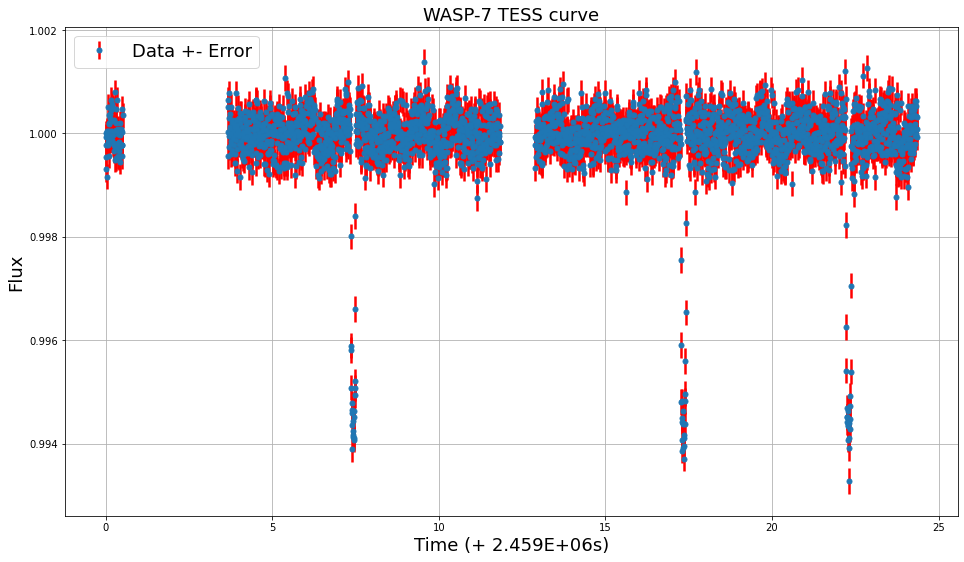

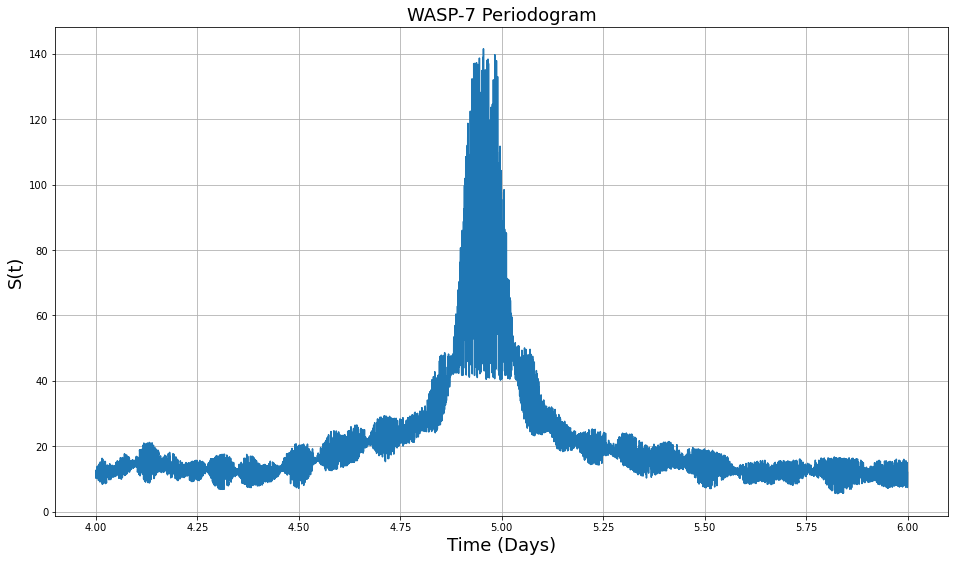

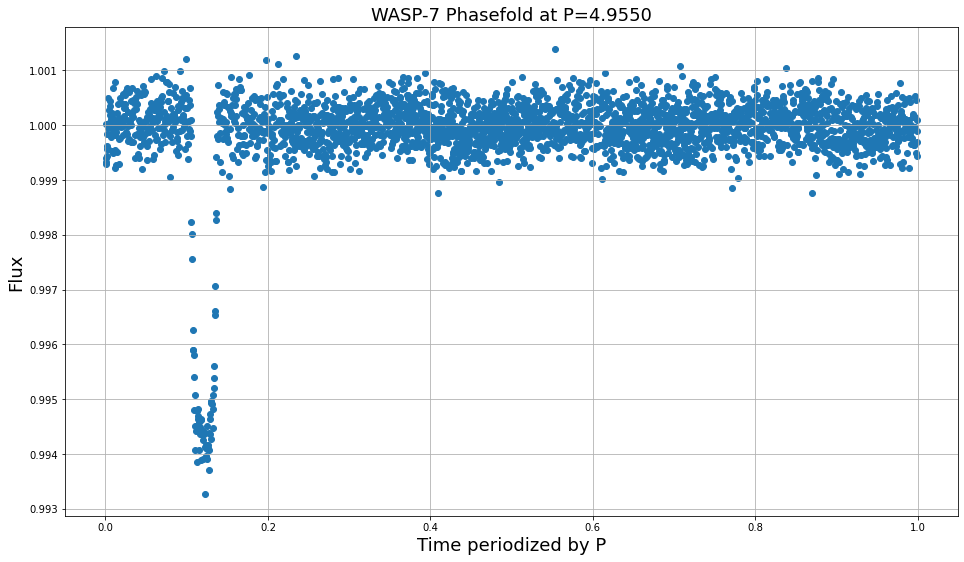

Best Period : 4.95499099819964
Relative Error : 0.007051936907796052%


In [10]:
""" WASP-7b """
Star = Model("./data/WASP-7_TOI-2197_FLUX.dat")
Star.MAIN(4.9546416, search=[4, 6, 5000])


## WASP-31b

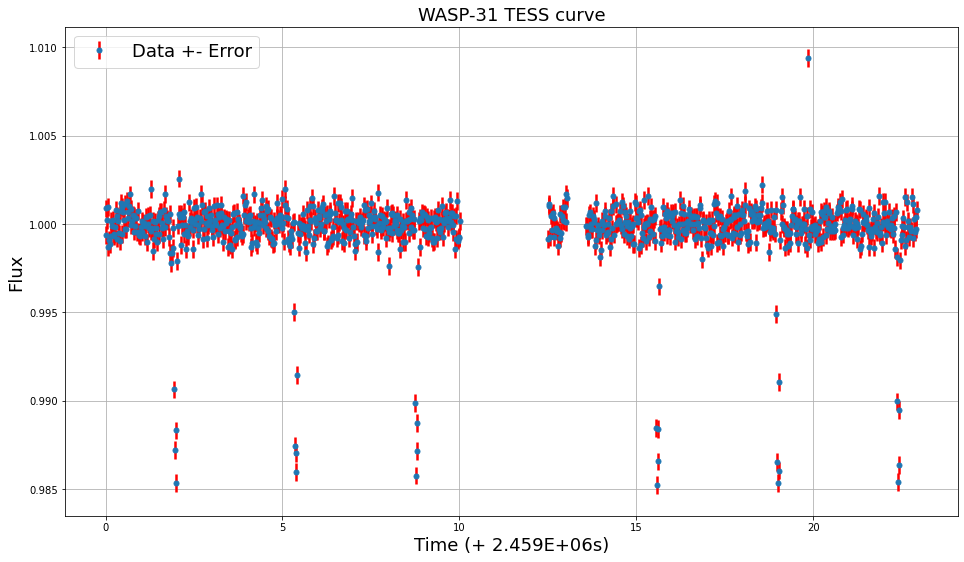

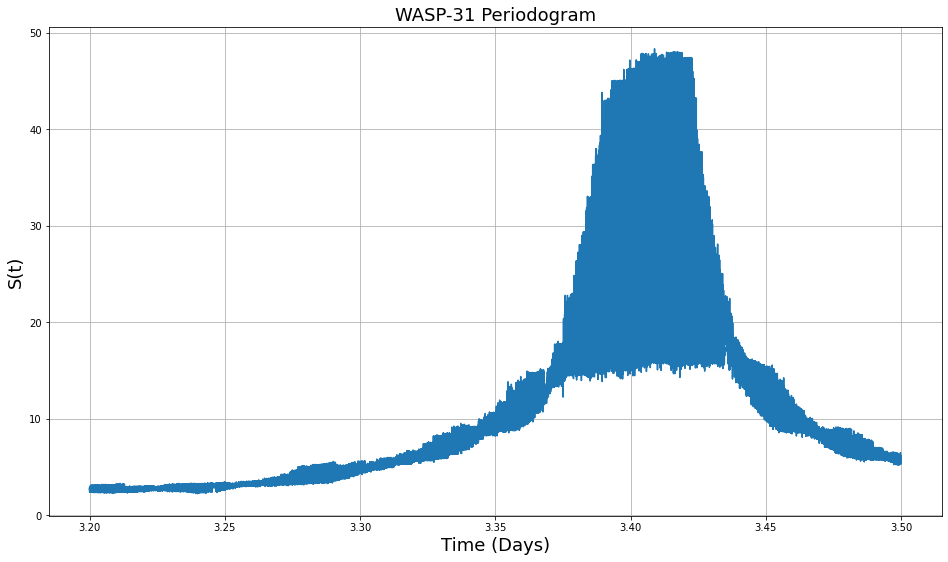

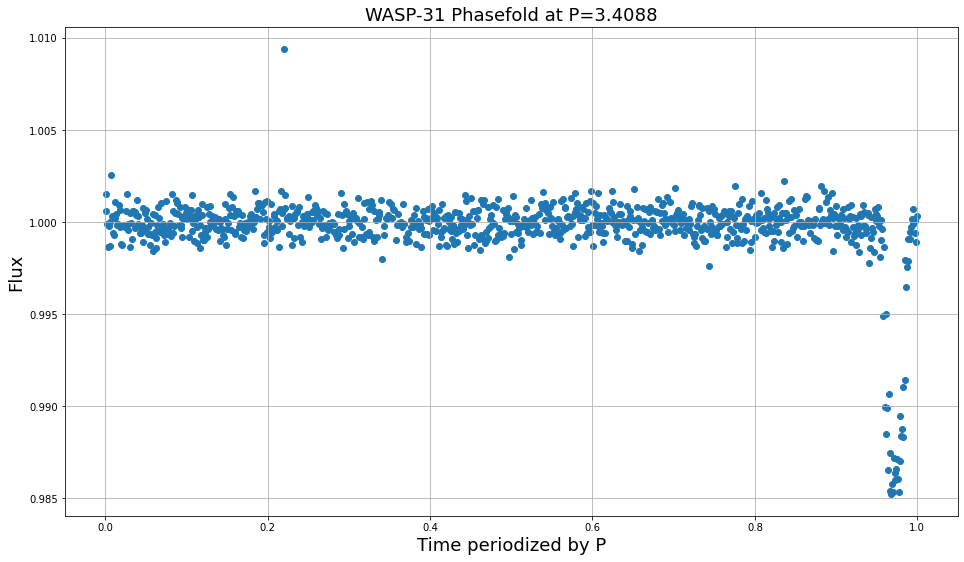

Best Period : 3.408840176803536
Relative Error : 0.0860615126104676%


In [11]:
""" WASP-31b """
Star = Model("./data/WASP-31_TOI-683_FLUX.dat")
Star.MAIN(3.405909, search=[3.2, 3.5, 50000])


## WASP-111b

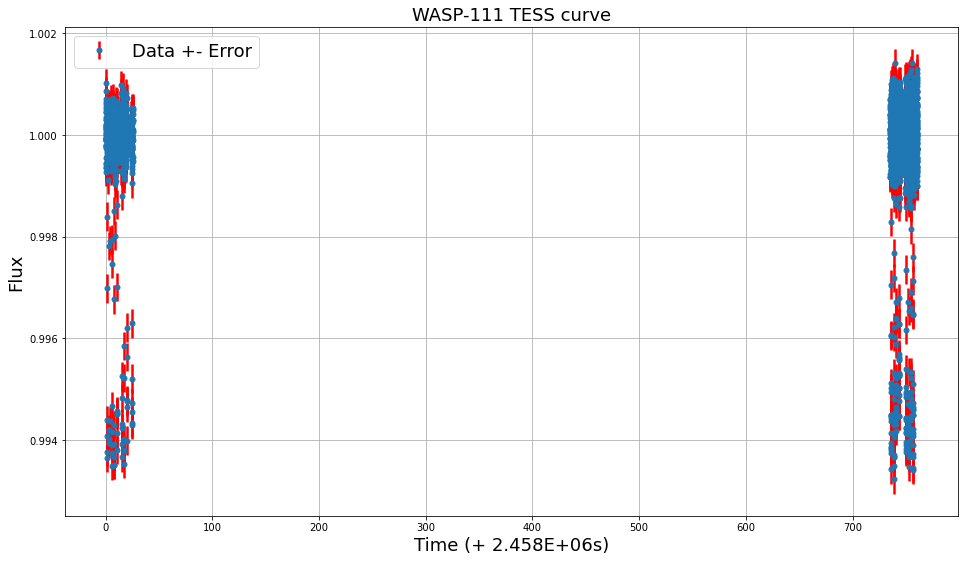

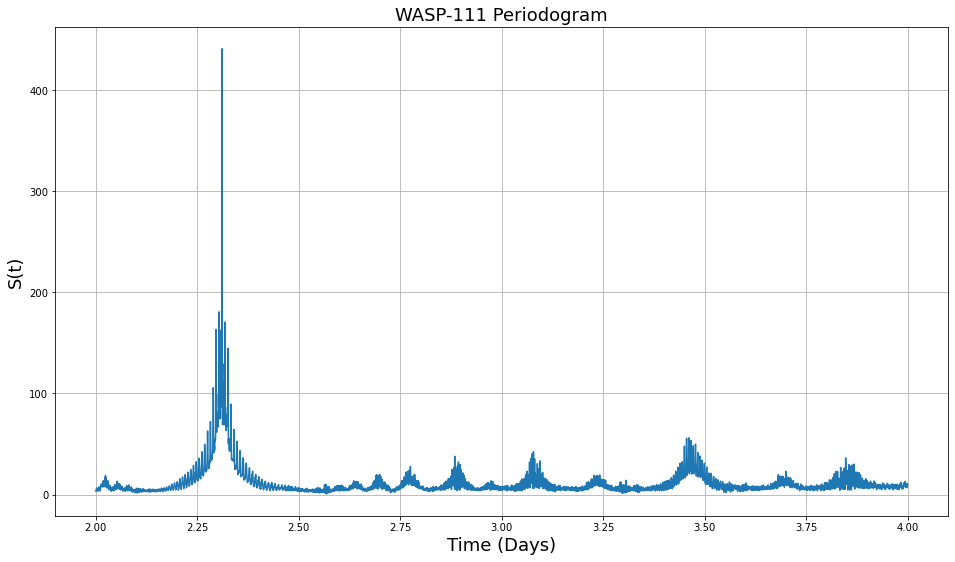

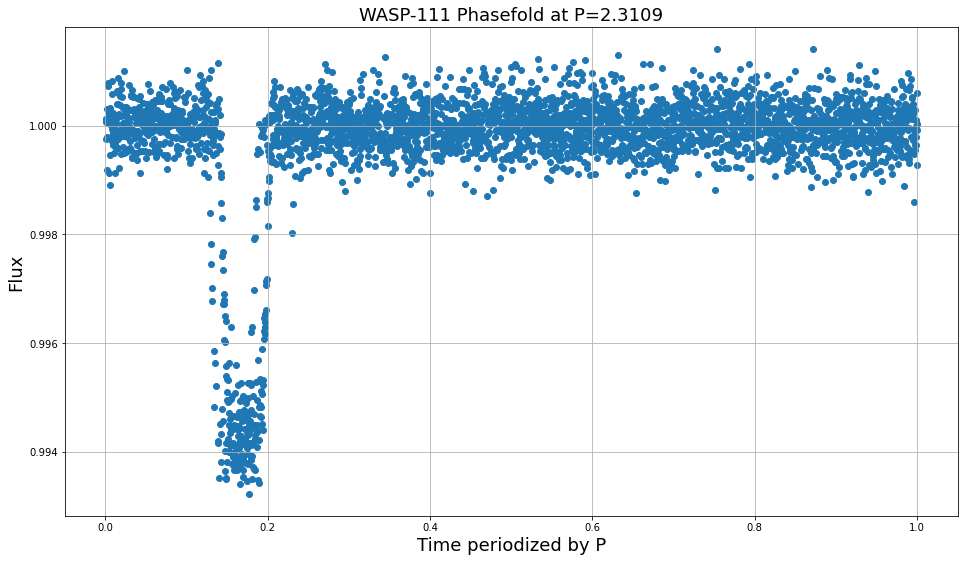

Best Period : 2.310862172434487
Relative Error : 0.004449550967368733%


In [12]:
""" WASP-111b """
Star = Model("./data/WASP-111_TOI-143_FLUX.dat")
Star.MAIN(2.310965, search=[2, 4, 5000])


## WASP-112b

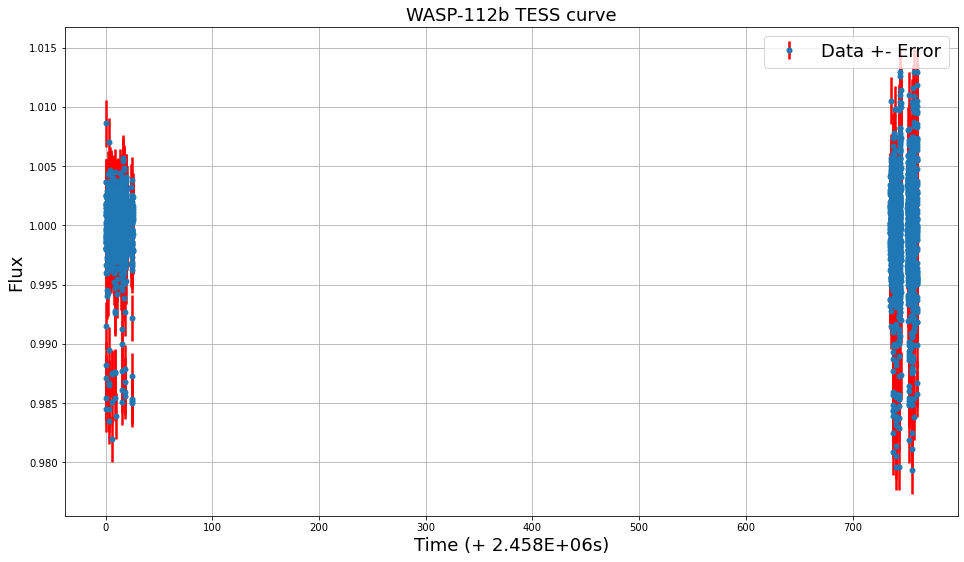

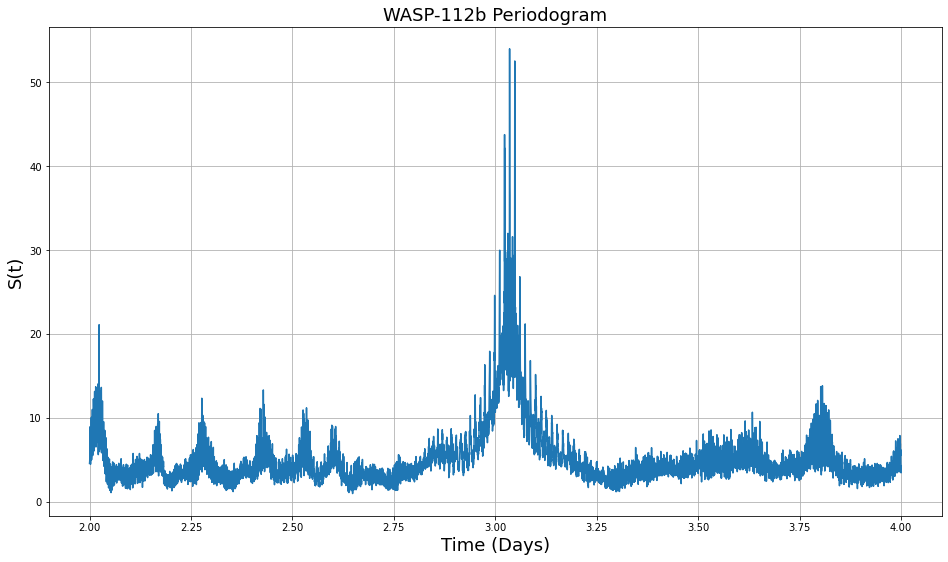

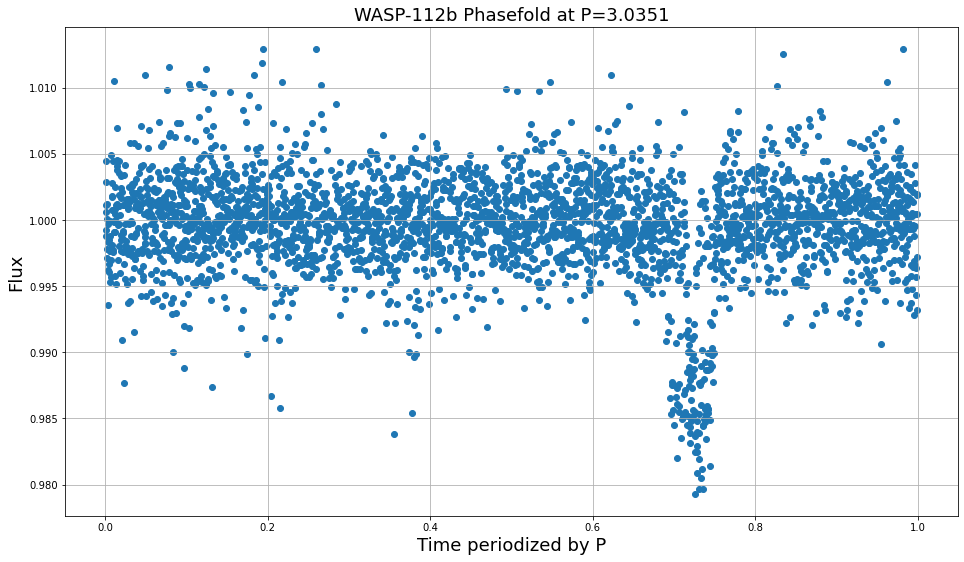

Best Period : 3.035103510351035
Relative Error : 0.009741375993147151%


In [13]:
""" WASP-112b """
Star = Model("./data/WASP-112b_TOI-126_FLUX.dat")
Star.MAIN(3.0353992, search=[2, 4, 10000])
